# Book Genre Prediction using machine learning

## prepared by Karol Wesołowski

### Learning task and preparation

The task of the algorithm is to predict a genre of a book based on a blurp. Blurp is a short description of a piece created by publisher, to promote the book and show the general content of it. Genre is usually a broad category used to classify books by sellers.

Data for the task comes from Kaggle and is presented in the form of csv file.

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

To perform the task it is required to use many python packages. For machine learning computations I used packages from sklearn family. For text analysis I used nltk package. Data is saved into Panda DataFrame format. Math operation using Numpy, to measure time I used default python time package. Graphs generated using pyplot and Seaborn. To improve computation time, I used Counter from collections package to create "bag of words".

### Data

In [2]:
data = pd.read_csv("data.csv", index_col=0)
print(data.head())

                           title    genre  \
index                                       
0              Drowned Wednesday  fantasy   
1                  The Lost Hero  fantasy   
2      The Eyes of the Overworld  fantasy   
3                Magic's Promise  fantasy   
4                 Taran Wanderer  fantasy   

                                                 summary  
index                                                     
0       Drowned Wednesday is the first Trustee among ...  
1       As the book opens, Jason awakens on a school ...  
2       Cugel is easily persuaded by the merchant Fia...  
3       The book opens with Herald-Mage Vanyel return...  
4       Taran and Gurgi have returned to Caer Dallben...  


Data consist of four columns:
- Index: Integer, not used in computation;
- Title: String, not used in computation;
- Genre: Enum String, proper generation of this field is the goal of the computation
- Summary: long String, blurp content, data used in computation


In [12]:
print("shape of the data frame ", data.shape)
print("does it contains missing values?\n", data.isna().any(), "\n_______")

shape of the data frame  (4657, 3)
does it contains missing values?
 title      False
genre      False
summary    False
dtype: bool 
_______


In [11]:
genres = data.groupby(["genre"])["genre"].count().sort_values(ascending=False)
print(genres)

genre
thriller      1023
fantasy        876
science        647
history        600
horror         600
crime          500
romance        111
psychology     100
sports         100
travel         100
Name: genre, dtype: int64


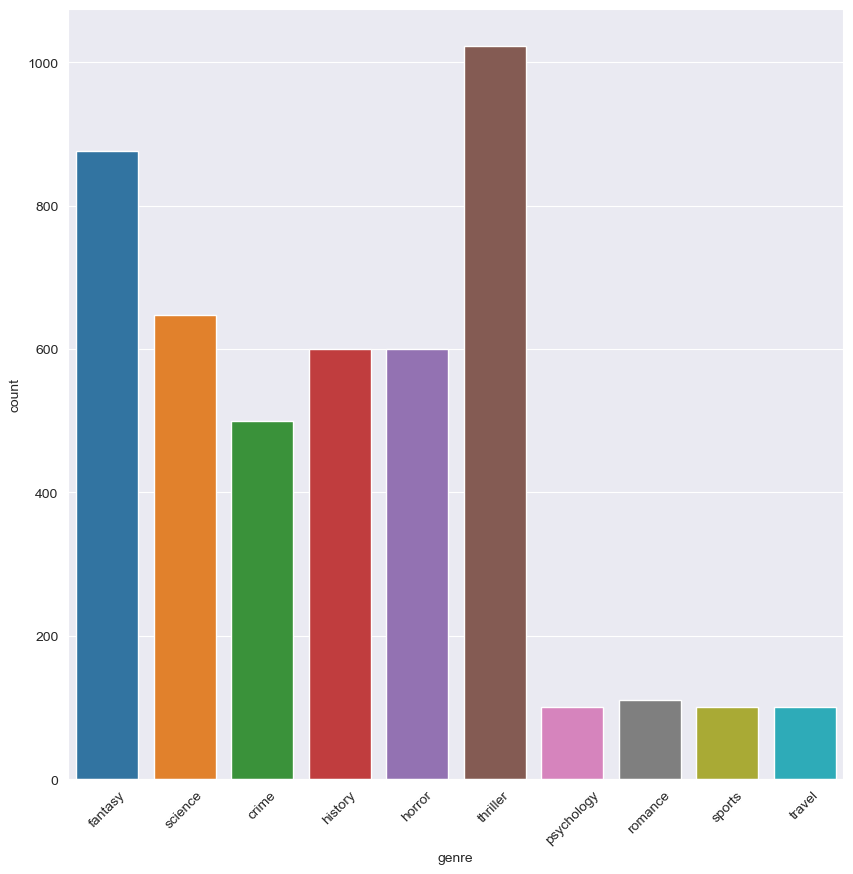

In [13]:
plt.figure(figsize=(10, 10))
g = sns.countplot(x="genre", data=data)
plt.xticks(rotation=45)
fig = g.get_figure()
fig.savefig("wykres1.png")
plt.show()

As seen in the computation output, data contains nearly 4,500 records, split into 10 genre categories. Every record is complete (doesn't contain None values). The most popular genre is "thriller", closely followed by "fantasy". Three genres: "psychology", "sport" and "travel" have 100 records each, which makes them the least popular categories.

For convenience reasons, graph generating code in original file is saved into a function ```graph(data)```, and its output is saved to a png file.

Next step in the computation is to clean the data and prepare it to text analysis. Every summary is sent to ```nlp_cleaning``` function, which performs following steps:
1. turn every word to lower case
2. split words into tokens
3. remove all tokens that are not "words" (e.g. numbers)
4. remove english stopwords downloaded from ```nltk.corpus.stopwords```
5. convert nouns into singular
6. convert verbs into base form
7. create dictionary of tokens and count of their appearance in text

Generated stems (processed tokens) and dictionary are added to 'data' DataFrame as "clean" and "word_dictionary" columns.
Because this function is very slow and time-consuming, its result is saved to csv file, and is meant to run only once. To follow progress it prints a dot ('.') every time it finishes computing.

In [14]:
def nlp_cleaning(data, output_filename):
    english_stops = set(stopwords.words("english"))
    wl = WordNetLemmatizer()
    new_col_stems = []
    new_col_dicts = []
    for summary in data["summary"]:
        print(".", end="")
        tokens = word_tokenize(summary.lower())  # split into tokens
        letters_only = [token for token in tokens if token.isalpha()]  # remove non-alpha
        no_stops = [token for token in letters_only if token not in english_stops]  # remove stop words
        stems = [wl.lemmatize(token) for token in no_stops]  # remove plural forms
        stems = [wl.lemmatize(token, 'v') for token in stems]  # change verbs to base form
        word_dict = Counter(stems)
        new_col_dicts.append(word_dict)
        new_col_stems.append(stems)
    data["clean"] = new_col_stems
    data["word_dictionary"] = new_col_dicts
    data.to_csv(output_filename)

To show the result I am using an excerpt of original data, containing first ten rows.

In [18]:
small = pd.read_csv("small.csv", index_col=0)
nlp_cleaning(small, "small_out.csv")
print("\n", small.head(5))

..........
                            title    genre  \
index                                       
0              Drowned Wednesday  fantasy   
1                  The Lost Hero  fantasy   
2      The Eyes of the Overworld  fantasy   
3                Magic's Promise  fantasy   
4                 Taran Wanderer  fantasy   

                                                 summary  \
index                                                      
0       Drowned Wednesday is the first Trustee among ...   
1       As the book opens, Jason awakens on a school ...   
2       Cugel is easily persuaded by the merchant Fia...   
3       The book opens with Herald-Mage Vanyel return...   
4       Taran and Gurgi have returned to Caer Dallben...   

                                                   clean  \
index                                                      
0      [drown, wednesday, first, trustee, among, morr...   
1      [book, open, jason, awaken, school, bus, unabl...   
2      [cug

Processed data is then reloaded into program.

### Literary Overview